In [77]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.8.0
Compiled: Mar 14 2014 02:43:02



In [80]:
img_T1_filename = '/Shared/sinapse/CACHE/20141001_PREDICTHD_long_Results/PHD_024/2263/78442/TissueClassify/t1_average_BRAINSABC.nii.gz'
img_T2_filename = '/Shared/sinapse/CACHE/20141001_PREDICTHD_long_Results/PHD_024/2263/78442/TissueClassify/t2_average_BRAINSABC.nii.gz'
img_labels_filename = '/Shared/sinapse/CACHE/20141001_PREDICTHD_long_Results/PHD_024/2263/78442/TissueClassify/neuro2012_20fusion_merge_seg.nii.gz'

img_T1 = sitk.ReadImage(img_T1_filename)
img_T2 = sitk.ReadImage(img_T2_filename)
img_labels = sitk.ReadImage(img_labels_filename)

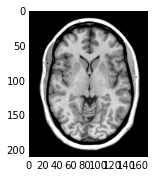

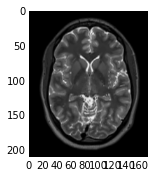

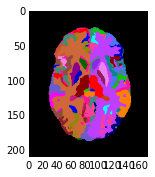

In [81]:
myshow(img_T1)
myshow(img_T2)
myshow(sitk.LabelToRGB(img_labels))

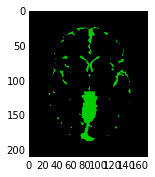

In [82]:
exclusionLabels=((img_labels == 11) + 
                 (img_labels == 35) + 
                 (img_labels == 38) + 
                 (img_labels == 39) + 
                 (img_labels == 40) +
                 (img_labels == 41) +
                 (img_labels == 51) +
                 (img_labels == 52) +
                 (img_labels == 71) + 
                 (img_labels == 72) + 
                 (img_labels == 73) + 
                 (img_labels == 230)+ 
                 (img_labels == 255))
myshow(sitk.LabelToRGB(exclusionLabels))

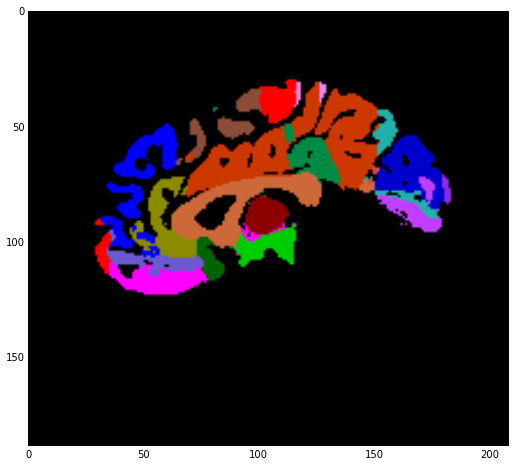

In [83]:
important_labels=img_labels*(1-exclusionLabels)
size = important_labels.GetSize()
myshow(sitk.Expand(sitk.LabelToRGB(important_labels[size[0]//2,:,::-1]),[3,3,3]))

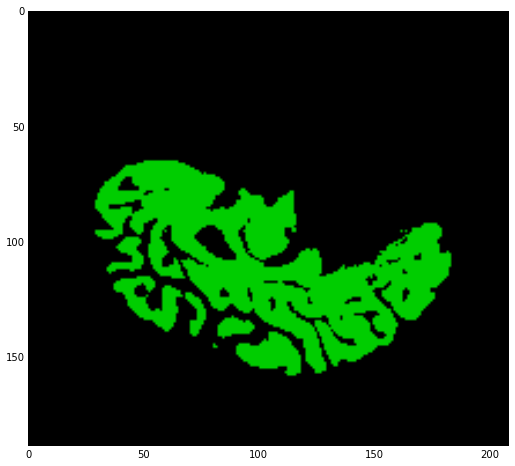

In [84]:
unified_important_labels=important_labels>0
myshow(sitk.Expand(sitk.LabelToRGB(unified_important_labels[size[0]//2,:,:]),[3,3,3]))

In [85]:
filter = sitk.LabelStatisticsImageFilter()
filter.Execute(img_T1, unified_important_labels)
bbox=filter.GetBoundingBox(1)
print(bbox)

(27, 145, 25, 186, 53, 163)


In [86]:
sitk.WriteImage(unified_important_labels,'/scratch/TESTS/BS/BTalairach/3_TalaiBoundingBoxUsingLabelMaps/unified_important_labels.nrrd')

In [87]:
I=bbox[4]
R=bbox[0]
P=bbox[3]
indx_IRP=[R,P,I]

S=bbox[5]
L=bbox[1]
A=bbox[2]
indx_SLA=[L,A,S]

print("IRP indeces: ",indx_IRP)
print("SLA indeces: ",indx_SLA)

IRP indeces:  [27, 186, 53]
SLA indeces:  [145, 25, 163]


In [88]:
itk_IRP = unified_important_labels.TransformIndexToPhysicalPoint(indx_IRP)
itk_SLA = unified_important_labels.TransformIndexToPhysicalPoint(indx_SLA)

IRP=[-itk_IRP[0],-itk_IRP[1],itk_IRP[2]]
SLA=[-itk_SLA[0],-itk_SLA[1],itk_SLA[2]]

print("IRP: ",IRP)
print("SLA: ",SLA)

IRP:  [59.5, -96.5, -36.5]
SLA:  [-58.5, 64.5, 73.5]


In [89]:
def csv_file_writer(filename,data):
  import csv
  with open(filename, 'w') as lf:
      headerdata1 = [['#Fiducial', 'List', 'file', filename],
                     ['#numPoints', '=', len(data)]]
      headerdata2 = [['#symbolScale = 5'],
                    ['#visibility = 1'],
                    ['#textScale = 4.5'],
                    ['#color = 0.4','1','1'],
                    ['#selectedColor = 1','0.5','0.5'],
                    ['#label','x','y','z','sel','vis']]
      wr = csv.writer(lf, delimiter=' ')
      wr.writerows(headerdata1)
      wr = csv.writer(lf, delimiter=',')
      wr.writerows(headerdata2)
      wr.writerows(data)

In [90]:
filename='/scratch/TESTS/BS/BTalairach/3_TalaiBoundingBoxUsingLabelMaps/test.fcsv'
data=[['SLA', SLA[0], SLA[1], SLA[2],1,1],
      ['IRP', IRP[0], IRP[1], IRP[2],1,1]]
csv_file_writer(filename,data)

In [91]:
print(data)

[['SLA', -58.5, 64.5, 73.5, 1, 1], ['IRP', 59.5, -96.5, -36.5, 1, 1]]


In [92]:
def csv_file_reader(filename,dataList):
   import csv
   with open(filename) as lf:
       reader = csv.reader(lf, delimiter=',')
       for line in reader:
         lmkName = line[0]
         if lmkName == "AC":
           #print("AC:",line)
           dataList.append(line)
         elif lmkName == "PC":
           #print("PC:",line)
           dataList.append(line)
         else:
           continue

In [93]:
inputFileName='/Shared/sinapse/CACHE/20141001_PREDICTHD_long_Results/PHD_024/2263/78442/ACPCAlign/BCD_ACPC_Landmarks.fcsv'
csv_file_reader(inputFileName,data)

In [94]:
print(data)

[['SLA', -58.5, 64.5, 73.5, 1, 1], ['IRP', 59.5, -96.5, -36.5, 1, 1], ['AC', '0.013121295335960514', '0.08373838555707636', '0.08395462777705864', '1', '1'], ['PC', '0.8311347699072642', '-26.604026977847898', '5.262203440362757', '1', '1']]


In [95]:
BTalairachLmkFilename='/scratch/TESTS/BS/BTalairach/3_TalaiBoundingBoxUsingLabelMaps/lmkList.fcsv'
csv_file_writer(BTalairachLmkFilename,data)

In [96]:
BRIANSToolsPath="/scratch/BS/release/bin"
BRAINSTalairachPath=os.path.join(BRIANSToolsPath,"BRAINSTalairach")
if not os.path.isfile(BRAINSTalairachPath):
    print("ERROR: This script requires that BRAINSTalairach can be found")
    print("{0} does not exists".format(BRAINSTalairachPath))

In [97]:
BTalairachoutputGridFilename='/scratch/TESTS/BS/BTalairach/3_TalaiBoundingBoxUsingLabelMaps/outputGrid.vtk'
BTalairachoutputBoxFilename='/scratch/TESTS/BS/BTalairach/3_TalaiBoundingBoxUsingLabelMaps/outputBox.vtk'

!{BRAINSTalairachPath} \
  --inputVolume {img_T1_filename} \
  --inputLandmarksFile {BTalairachLmkFilename} \
  --outputGrid {BTalairachoutputGridFilename} \
  --outputBox {BTalairachoutputBoxFilename}

Reading landmark points from fcsv file...
AC: -0.0131213 -0.0837384 0.0839546
PC: -0.831135 26.604 5.2622
IRP: -59.5 96.5 -36.5
SLA: 58.5 -64.5 73.5
ACisIndex: 0
PCisIndex: 0
IRPisIndex: 0
SLAisIndex: 0
Image: /Shared/sinapse/CACHE/20141001_PREDICTHD_long_Results/PHD_024/2263/78442/TissueClassify/t1_average_BRAINSABC.nii.gz
Talairach Grid: /scratch/TESTS/BS/BTalairach/3_TalaiBoundingBoxUsingLabelMaps/outputGrid.vtk
Talairach Box: /scratch/TESTS/BS/BTalairach/3_TalaiBoundingBoxUsingLabelMaps/outputBox.vtk
grid pnts in talgrid::GetTalairachGrid:: 1620
